In [204]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import imageio
import time

import pypom

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In this example code we use POM to detect people at one given time

# Loading the inputs

In [300]:
views = ['gopro6.0', 'gopro6.1', 'gopro6.2', 'gopro6.3']
masks = {view:imageio.imread("./bgsub_{}.png".format(view)) for view in views}

intrinsics = {view:pypom.utils.json_read("./calibration/intrinsics_{}.json".format(view)) for view in views}
extrinsics = {view:pypom.utils.json_read("./calibration/extrinsics_{}.json".format(view)) for view in views}

# Checking the masks

<IPython.core.display.Javascript object>


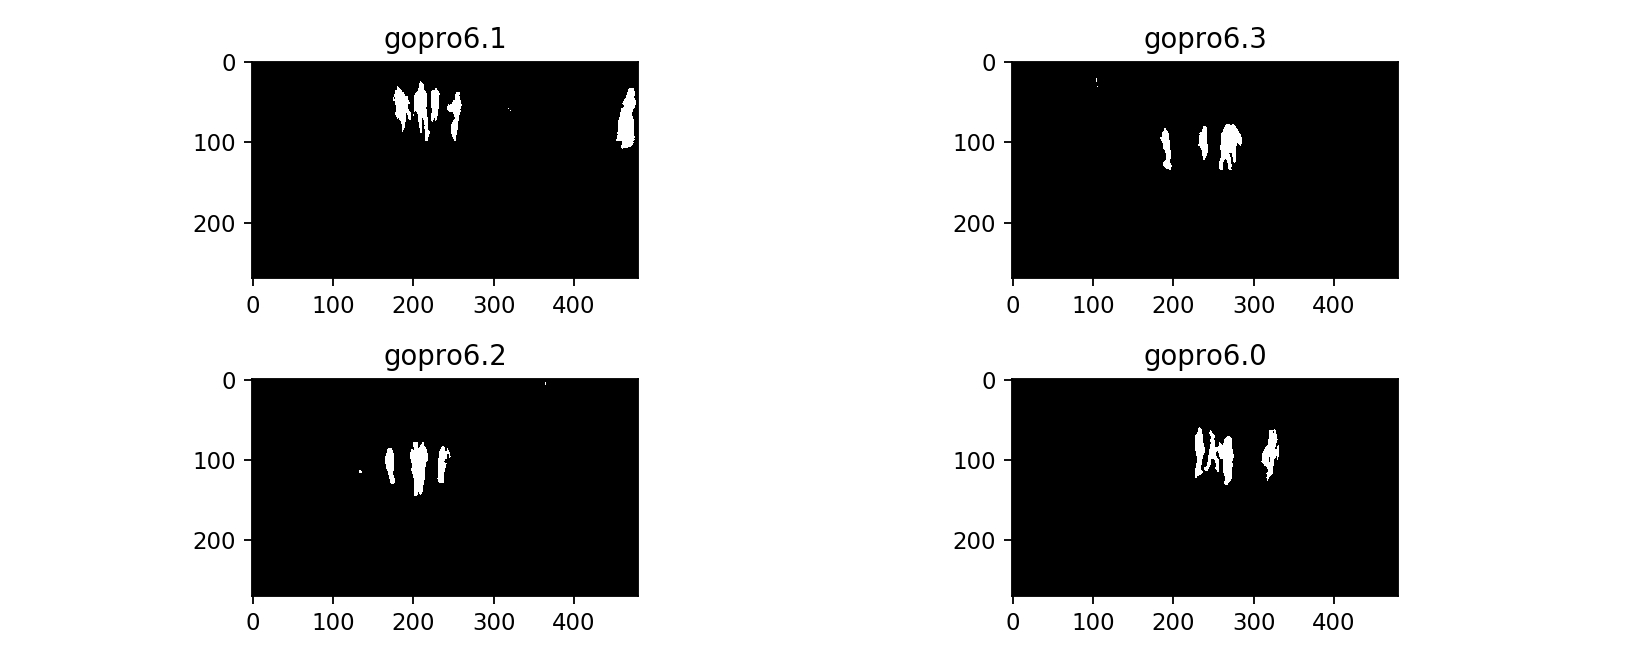

In [301]:
plt.figure(figsize=(10,4))
for i, (view, mask) in enumerate(masks.items()):
    plt.subplot(2,2,i+1)
    plt.imshow(mask)
    plt.title(view)
plt.tight_layout()

# Preparing the ground grid

In [302]:
scale = 0.25 # scaling factor for the input images/masks. Reducing the size of the images makes POM faster
# the calibration has been done in centimeters but you are free to use any unit. 
# You can convert the unit of the calibration in the camera models i fneeded!
man_ray = 12
man_height = 170 
room = pypom.Room(width = 1000, 
                  height = 700, 
                  step_x = 10, 
                  step_y = 10, 
                  origin_x=-600, 
                  origin_y=-700, 
                  origin_z=0.0)
world_grid = room.get_world_grid()

print("grid:({},{})".format(room.n_width, room.n_height))
print("n_positions:", room.n_positions)

grid:(100,70)
n_positions: 7000


## Checking the ground grid

<IPython.core.display.Javascript object>


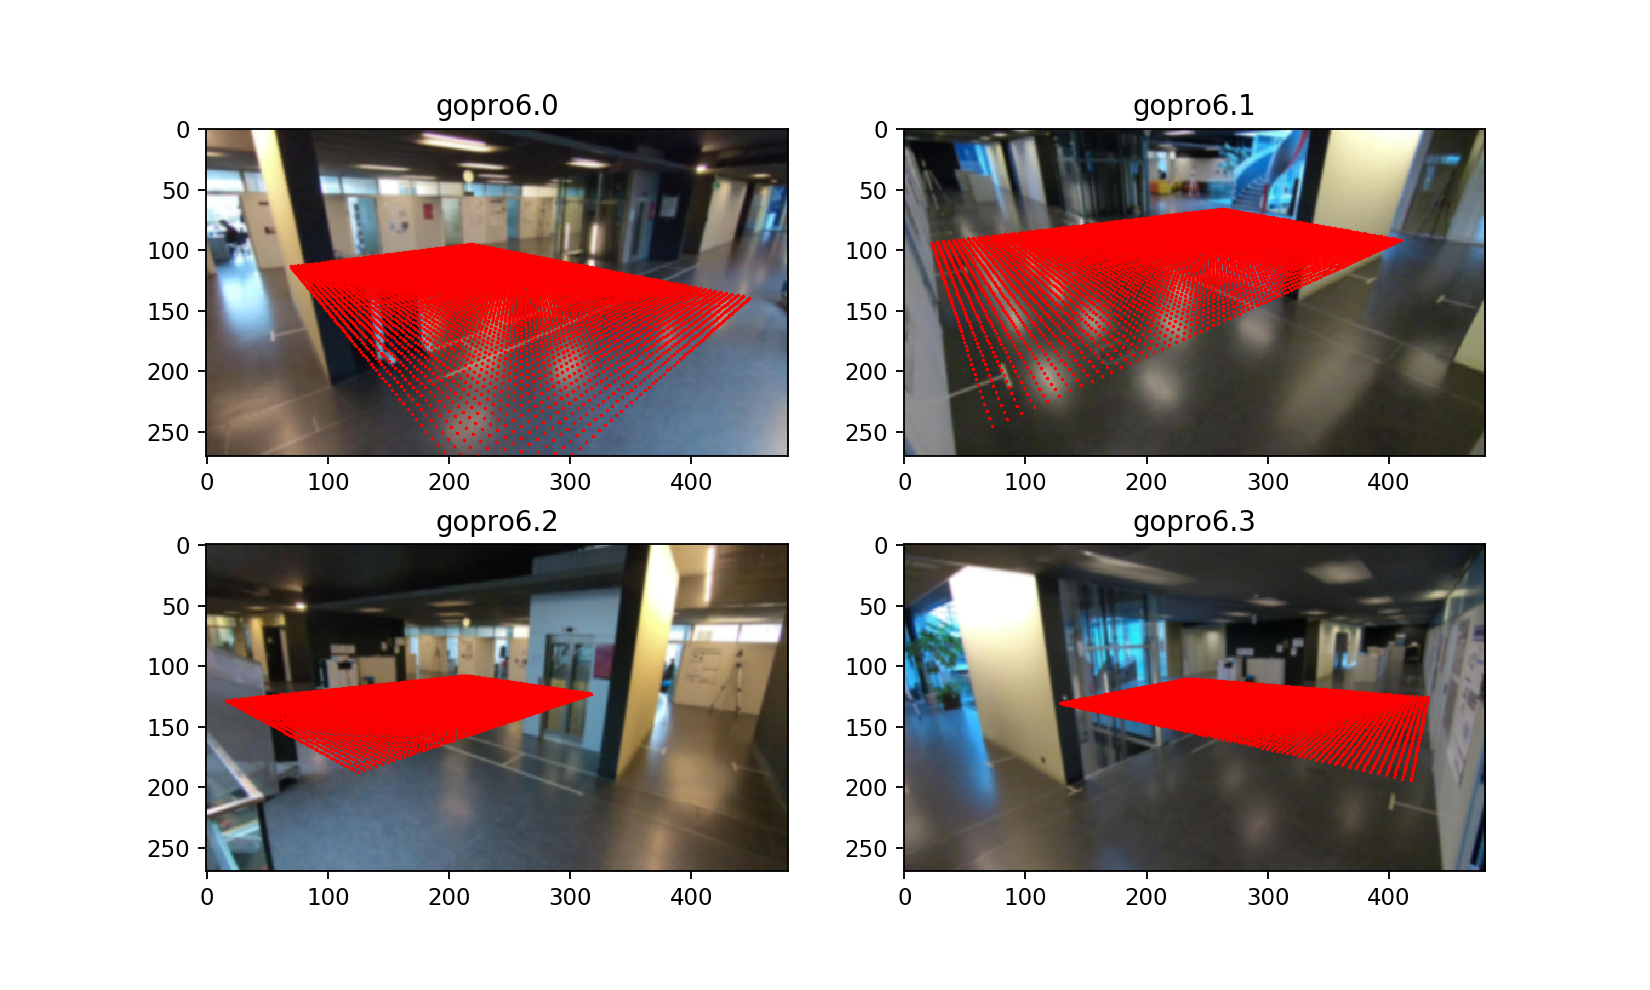

In [303]:
plt.figure(figsize=(10,6))
for i,view in enumerate(views):

    K = np.float32(intrinsics[view]['K'])
    R = np.float32(extrinsics[view]['R'])
    t = np.float32(extrinsics[view]['t'])

    img = imageio.imread("frame_{}.jpg".format(view))
    img = pypom.utils.downsample_image(img, masks[view].shape)

    cam = pypom.camera.CameraKRt(view, K, R, t, scale=scale)
    proj = cam.project_points(world_grid)

    plt.subplot(2,2,i+1)
    plt.plot(proj[:,0], proj[:,1], 'r.', markersize=1)
    plt.imshow(img)
    plt.title(view)

# Preparing the rectangles

In [304]:
all_rectangles = []
cameras = {}
for view in views:
    
    K = np.float32(intrinsics[view]['K'])
    R = np.float32(extrinsics[view]['R'])
    t = np.float32(extrinsics[view]['t'])
    
    cam = pypom.CameraKRt(view, K, R, t, scale=scale)
    cameras[view] = cam
    view_shape = masks[view].shape
        
    rectangles = pypom.generate_rectangles(world_grid, cam, man_ray, man_height, view_shape,
                                           p_visible=0.7, verbose=True, threads=8)
    all_rectangles.append(rectangles)

[gopro6.0]::Generated rectangles: 7000.
[gopro6.1]::Generated rectangles: 7000.
[gopro6.2]::Generated rectangles: 7000.
[gopro6.3]::Generated rectangles: 7000.


<IPython.core.display.Javascript object>


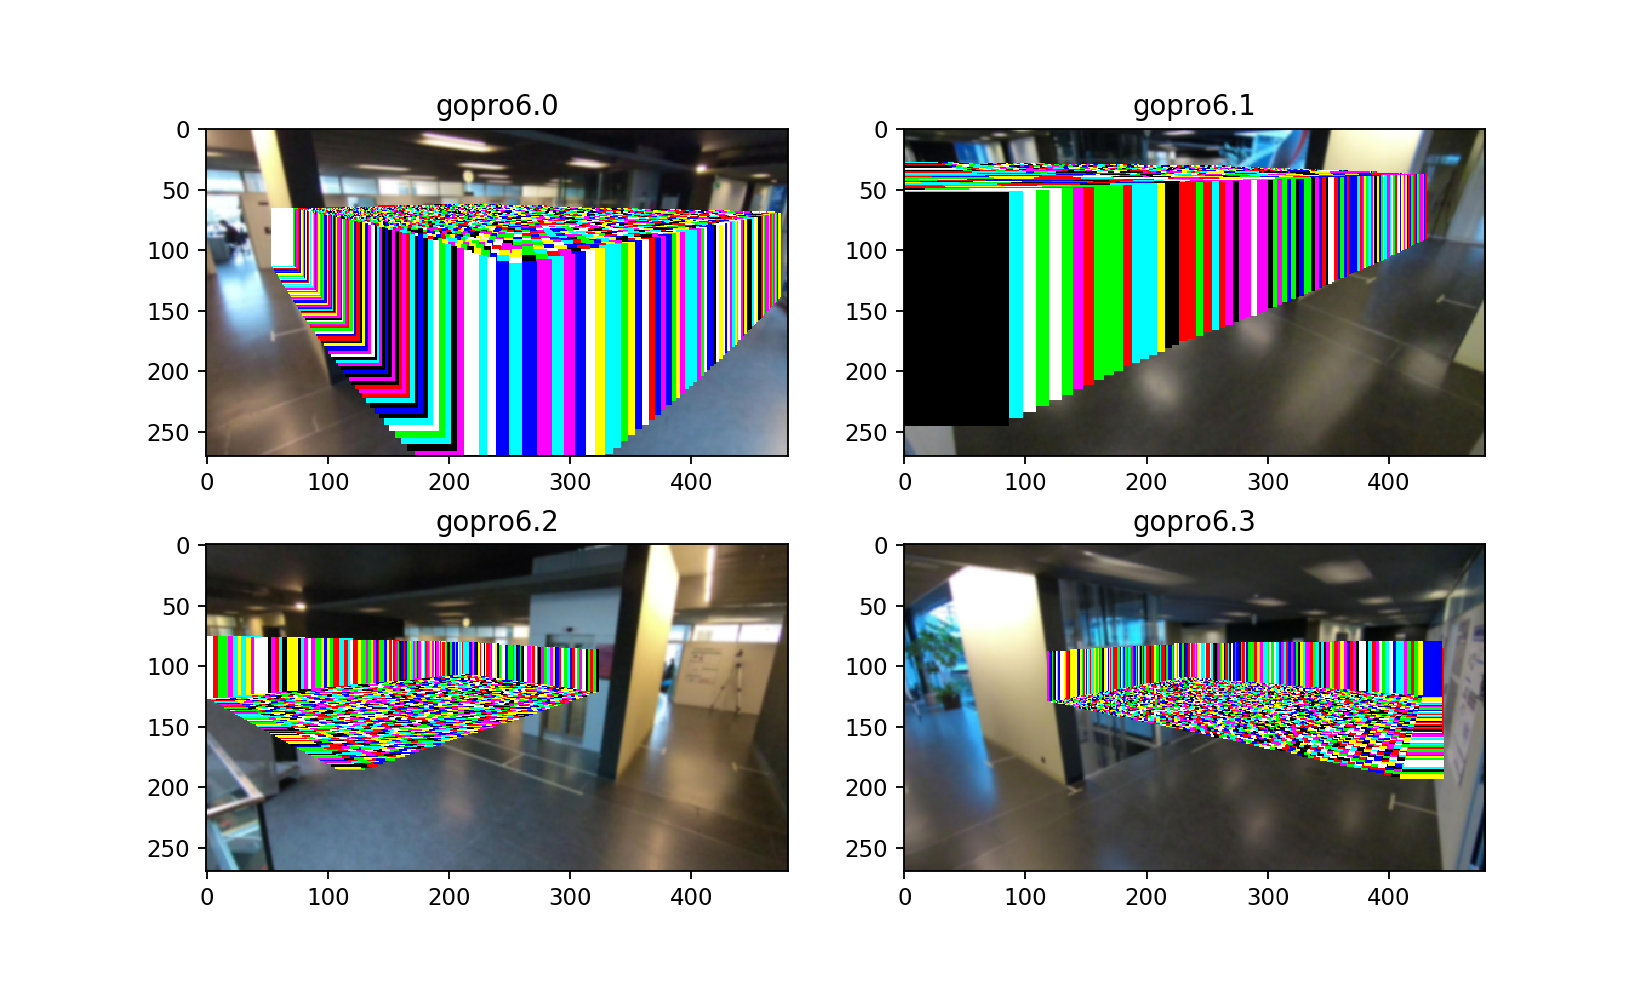

In [305]:
plt.figure(figsize=(10,6))
for i,(view,rects) in enumerate(zip(views, all_rectangles)):

    img = imageio.imread("frame_{}.jpg".format(view))
    img = pypom.utils.downsample_image(img, masks[view].shape)
    
    for rect in rects:
        if rect.visible:
            img[rect.slices()] = (np.random.rand(3)>0.5)*255

    plt.subplot(2,2,i+1)
    plt.imshow(img)
    plt.title(view)

# Run POM solver

In [310]:
start_time = time.time()

# setting these parameters is a bit of an art
prior=1e-5
sigma=0.03 # the less the more it is sensitive to the background substraction noise
step=0.8
max_iter=100
tol=1e-5

solv = pypom.Solver(all_rectangles, prior, sigma, step, max_iter, tol)

# this need to be called once at the beginning of a sequence. Not before every frame
q = solv.generate_prior()

probability_of_presences = []
for idx in range(0,1):
    
    masks_ = [np.float32(masks[view]/255.) for view in views]

    idx = 0
    qs = solv.run(idx, masks_, q, verbose=True, debug=True) # debug=True makes it very slow!
    q = qs[-1]
    print("Number of people detected: ", len(np.where(np.array(q)>0.9)[0]))

    probability_of_presences.append(q)

print("Elapsed time: {:0.2f}s".format(time.time()-start_time))

[Solver]::Idx 0000 (diff=4.16E-06<tol) |||||||||||||||>_____| [59.77s] Solved at iteration: 73 (diff=4.16E-06<tol)
Number of people detected:  4
Elapsed time: 59.81s


# Visualise the detections

<IPython.core.display.Javascript object>


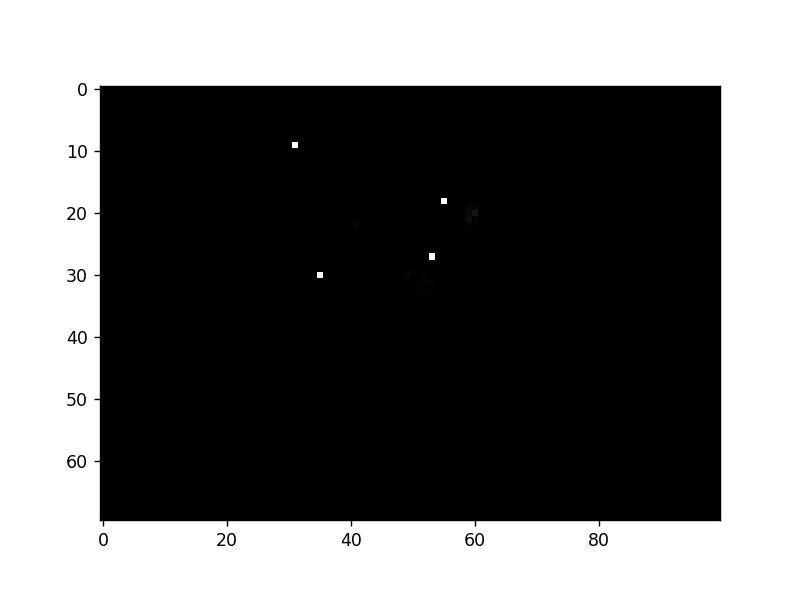

<IPython.core.display.Javascript object>


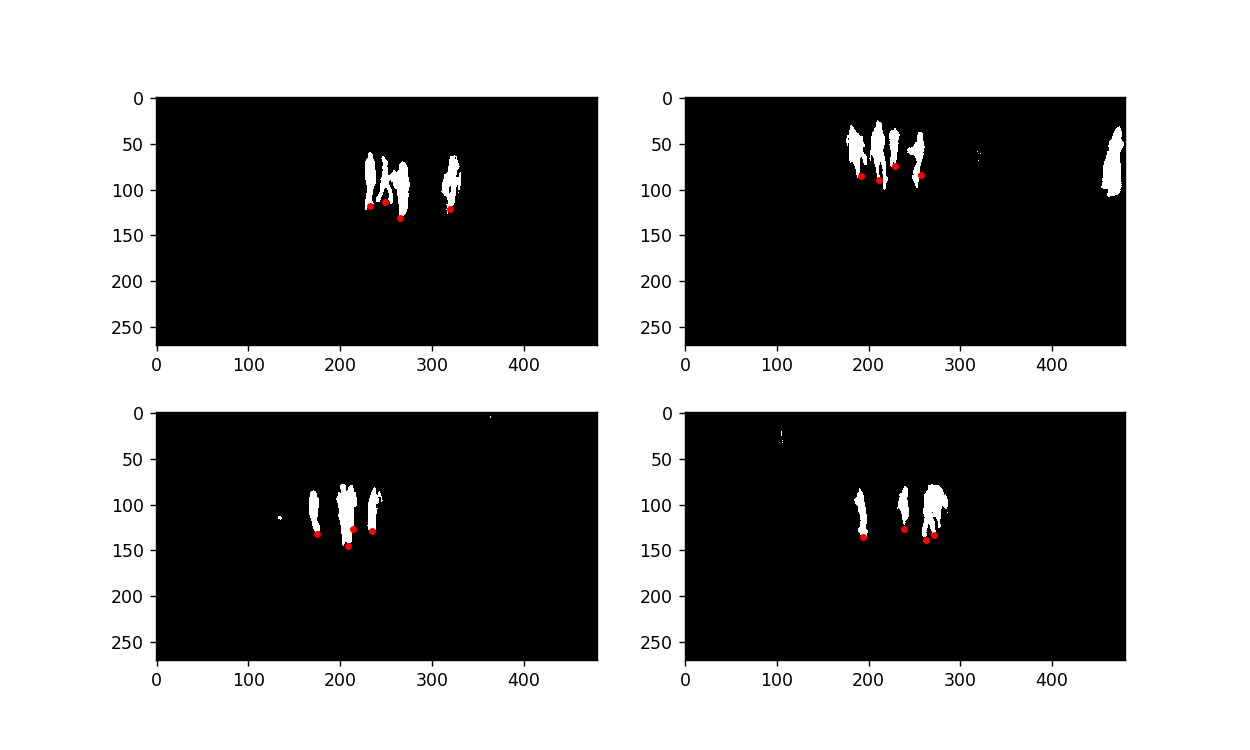

In [311]:
q = probability_of_presences[0]

plt.figure()
plt.imshow(q.reshape(room.n_height, room.n_width))

detections = room.from_ID_to_position(np.where(q>0.9)[0])

plt.figure(figsize=(10,6))
for i,view in enumerate(views):
    projs = cameras[view].project_points(np.float32(detections))

    plt.subplot(2,2,i+1)
    plt.imshow(masks[view])
    plt.plot(projs[:,0], projs[:,1], 'r.')

<IPython.core.display.Javascript object>


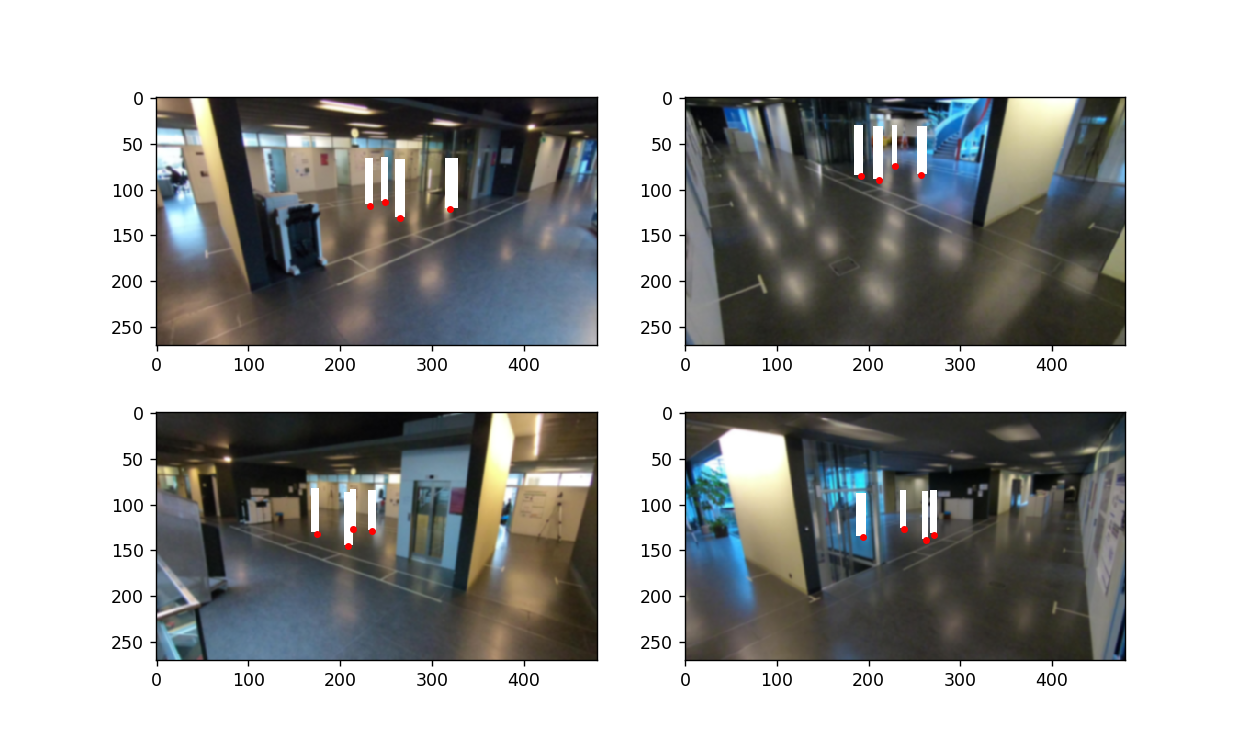

In [312]:
plt.figure(figsize=(10,6))
for i,(view, rects) in enumerate(zip(views, all_rectangles)):
    
    projs = cameras[view].project_points(np.float32(detections))
    
    img = imgs[view].copy()
    img = pypom.utils.downsample_image(img, masks[view].shape)
    
    for j in np.where(q>0.9)[0]:
        img[rects[j].slices()] = [255,255,255]

    plt.subplot(2,2,i+1)
    plt.imshow(img)
    plt.plot(projs[:,0], projs[:,1], 'r.')